In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [35]:
# Constants
INPUT_LENGTH = 13
NUM_AMINO_ACIDS = 21
EMBEDDING_DIM = 20
OUTPUT_CLASSES = 3

# Model architecture
model1 = Sequential()
model1.add(Embedding(NUM_AMINO_ACIDS, EMBEDDING_DIM, input_length=INPUT_LENGTH))
model1.add(Flatten())
model1.add(Dense(40, activation='sigmoid'))
model1.add(Dense(OUTPUT_CLASSES, activation='softmax'))

# Compile model
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
def get_data_labels(file_path):
    data = []
    labels = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # remove leading/trailing whitespaces
            if line.startswith('#') or line == '' or line == '<>':
                continue
            elif line == 'end' or line == '<end>':
                data.append('end')
                labels.append('end')
            else:
                d, l = line.split(' ')
                data.append(d)
                labels.append(l)

    return data, labels

In [37]:
data_train, labels_train = get_data_labels('Q_and_s_data\protein-secondary-structure.train.txt')
data_test, labels_test = get_data_labels('Q_and_s_data\protein-secondary-structure.test.txt')

In [38]:
aa_to_int = {aa: i+1 for i, aa in enumerate('ACDEFGHIKLMNPQRSTVWY')}
aa_to_int[' '] = 0  # Using 0 for spacer or unknown amino acids

def encode_data(data, encoding_dict):
    return [encoding_dict.get(item, 0) for item in data]

def encode_labels(labels):
    label_to_int = {'_': 0, 'e': 1, 'h': 2}
    return [label_to_int.get(label, 0) for label in labels]

def sliding_window(data, labels, window_size):
    assert len(data) == len(labels)
    data_windows = []
    label_windows = []
    for i in range(len(data) - window_size + 1):
        data_windows.append(data[i:i+window_size])
        label_windows.append(labels[i+window_size//2])
    return data_windows, label_windows

# Encoding data and labels
data_train_encoded = encode_data(data_train, aa_to_int)
labels_train_encoded = encode_labels(labels_train)
data_test_encoded = encode_data(data_test, aa_to_int)
labels_test_encoded = encode_labels(labels_test)

# Creating windows
window_size = 13
data_train_windows, labels_train_windows = sliding_window(data_train_encoded, labels_train_encoded, window_size)
data_test_windows, labels_test_windows = sliding_window(data_test_encoded, labels_test_encoded, window_size)

# Convert data and labels to numpy arrays
X_train = np.array(data_train_windows)
y_train = np.array(labels_train_windows)
X_test = np.array(data_test_windows)
y_test = np.array(labels_test_windows)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(18184, 13) (18184,) (3523, 13) (3523,)


In [39]:
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print("X_train shape:", X_train.shape)
print("y_train_cat shape:", y_train_cat.shape)
print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)

X_train shape: (18184, 13)
y_train_cat shape: (18184, 3)
X_test shape: (3523, 13)
y_test_cat shape: (3523, 3)


In [40]:
# Train model
history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64)

Epoch 1/100
285/285 [==============================] - 1s 2ms/step - loss: 0.9625 - accuracy: 0.5323 - val_loss: 0.8464 - val_accuracy: 0.6242
Epoch 2/100
285/285 [==============================] - 0s 1ms/step - loss: 0.8214 - accuracy: 0.6285 - val_loss: 0.8173 - val_accuracy: 0.6406
Epoch 3/100
285/285 [==============================] - 0s 1ms/step - loss: 0.8076 - accuracy: 0.6362 - val_loss: 0.8175 - val_accuracy: 0.6415
Epoch 4/100
285/285 [==============================] - 0s 1ms/step - loss: 0.8041 - accuracy: 0.6368 - val_loss: 0.8189 - val_accuracy: 0.6336
Epoch 5/100
285/285 [==============================] - 0s 2ms/step - loss: 0.8021 - accuracy: 0.6384 - val_loss: 0.8239 - val_accuracy: 0.6333
Epoch 6/100
285/285 [==============================] - 0s 1ms/step - loss: 0.8000 - accuracy: 0.6394 - val_loss: 0.8208 - val_accuracy: 0.6384
Epoch 7/100
285/285 [==============================] - 0s 1ms/step - loss: 0.7985 - accuracy: 0.6413 - val_loss: 0.8225 - val_accuracy: 0.6330

111/111 [==============================] - 0s 761us/step


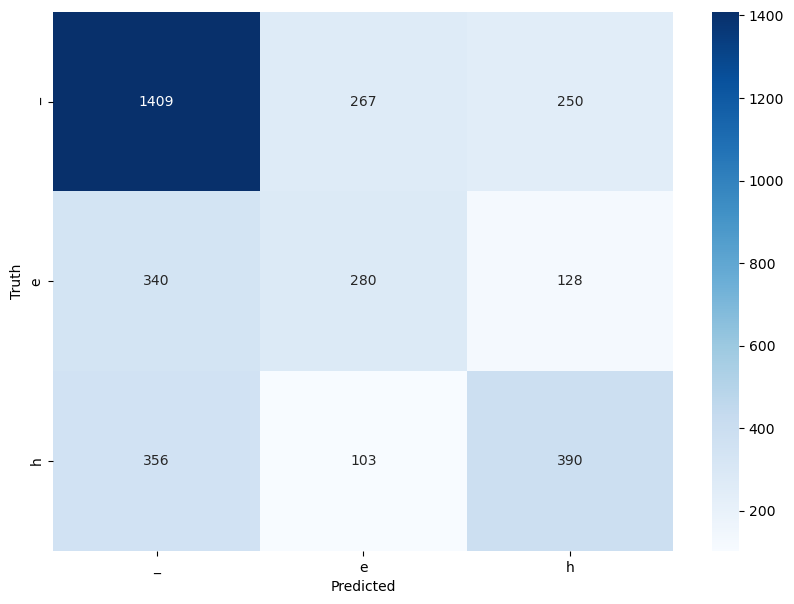

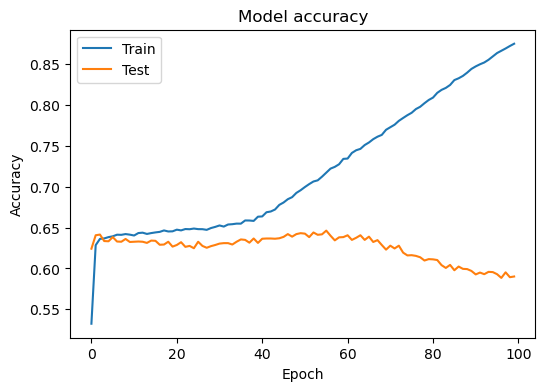

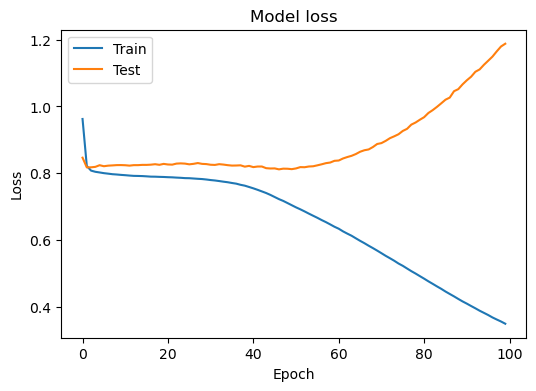

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Predict classes
y_pred_prob = model1.predict(X_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['_','e','h'], yticklabels=['_','e','h'],)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Plot training & validation accuracy values
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Model Improvement

In [42]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.regularizers import l2

# Constants
INPUT_LENGTH = 13
NUM_AMINO_ACIDS = 21
EMBEDDING_DIM = 20
OUTPUT_CLASSES = 3
FILTERS = 64
KERNEL_SIZE = 3
DROPOUT_RATE = 0.5
L2_REG = 0.001

# Model architecture
model2 = Sequential()
model2.add(Embedding(NUM_AMINO_ACIDS, EMBEDDING_DIM, input_length=INPUT_LENGTH))
model2.add(Conv1D(FILTERS, KERNEL_SIZE, activation='relu', kernel_regularizer=l2(L2_REG)))
model2.add(MaxPooling1D())
model2.add(Dropout(DROPOUT_RATE))
model2.add(Flatten())
model2.add(Dense(40, activation='sigmoid', kernel_regularizer=l2(L2_REG)))
model2.add(Dropout(DROPOUT_RATE))
model2.add(Dense(OUTPUT_CLASSES, activation='softmax'))

# Compile the model
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Epoch 1/100
285/285 [==============================] - 2s 4ms/step - loss: 1.0647 - accuracy: 0.5227 - val_loss: 0.9332 - val_accuracy: 0.5859
Epoch 2/100
285/285 [==============================] - 1s 4ms/step - loss: 0.9406 - accuracy: 0.5873 - val_loss: 0.9013 - val_accuracy: 0.6188
Epoch 3/100
285/285 [==============================] - 1s 4ms/step - loss: 0.9083 - accuracy: 0.6053 - val_loss: 0.8757 - val_accuracy: 0.6316
Epoch 4/100
285/285 [==============================] - 1s 4ms/step - loss: 0.8931 - accuracy: 0.6125 - val_loss: 0.8660 - val_accuracy: 0.6424
Epoch 5/100
285/285 [==============================] - 1s 4ms/step - loss: 0.8859 - accuracy: 0.6086 - val_loss: 0.8650 - val_accuracy: 0.6355
Epoch 6/100
285/285 [==============================] - 1s 3ms/step - loss: 0.8828 - accuracy: 0.6120 - val_loss: 0.8619 - val_accuracy: 0.6486
Epoch 7/100
285/285 [==============================] - 1s 3ms/step - loss: 0.8789 - accuracy: 0.6156 - val_loss: 0.8588 - val_accuracy: 0.6395

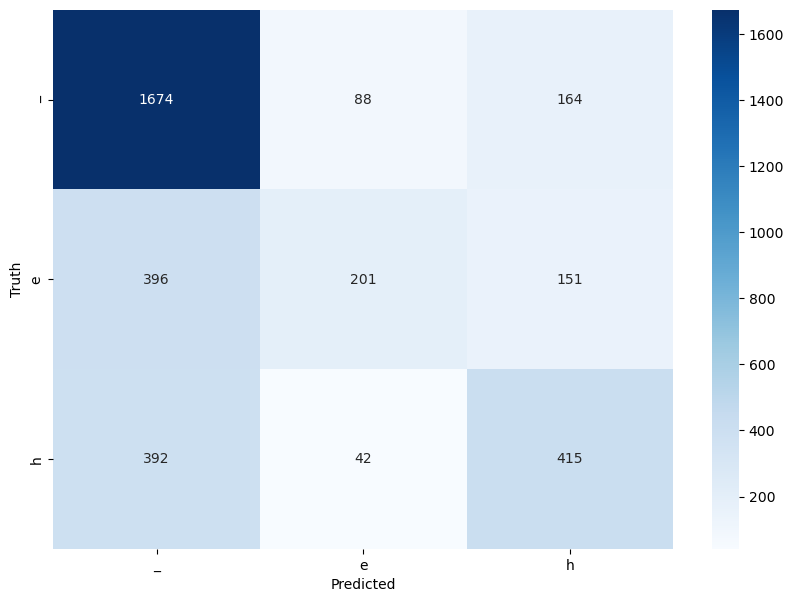

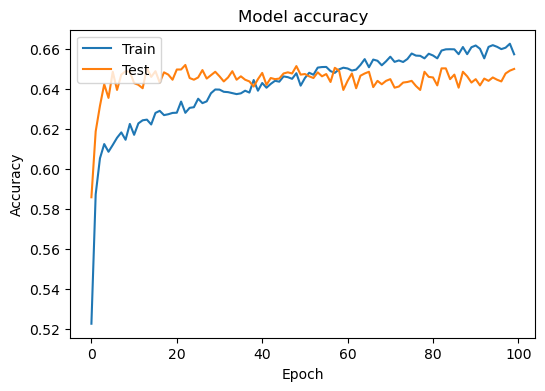

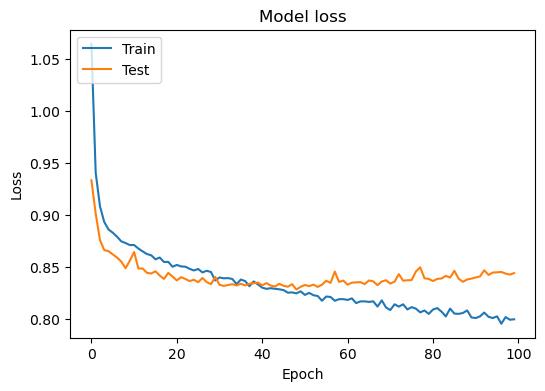

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Train model
history = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64)

# Predict classes
y_pred_prob = model2.predict(X_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['_','e','h'], yticklabels=['_','e','h'],)
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Plot training & validation accuracy values
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [44]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('2018-06-06-pdb-intersect-pisces.csv')

# Select only the 'seq' and 'sst3' columns
df = df[['seq', 'sst3']]

# Define the allowed characters
allowed_chars = set('ACDEFGHIKLMNPQRSTVWY')

# Iterate over the DataFrame and remove rows with sequences containing not allowed characters
df = df[df['seq'].apply(lambda seq: set(seq).issubset(allowed_chars))]

# Replace characters in the labels
df['sst3'] = df['sst3'].map(lambda sst3: sst3.replace('C', '_').replace('E', 'e').replace('H', 'h'))

# Print the first 5 rows to check the data
print(df.head())

                    seq                  sst3
0  NPVVHFFKNIVTPRTPPPSQ  _____e______________
1  DLDLEMLAPYIPMDDDFQLR  _________e______ee__
2  EEDPDLKAAIQESLREAEEA  ___hhhhhhhhhhhhhhh__
4  TTYADFIASGRTGRRNAIHD  _hhhhhh__________ee_
5  QDSRRSADALLRLQAMAGIS  _hhhhhhhhhhhhhhhh___


In [45]:
# Initialize the lists
data = []
labels = []

# Iterate over the DataFrame
for _, row in df.iterrows():
    # Append each character of the sequence to the data list
    for char in row['seq']:
        data.append(char)
    # Append 'end' to the data list
    data.append('end')

    # Append each character of the label to the labels list
    for char in row['sst3']:
        labels.append(char)
    # Append 'end' to the labels list
    labels.append('end')

# Print the first 50 elements of the lists to check the data
print(data[:50])
print(labels[:50])

['N', 'P', 'V', 'V', 'H', 'F', 'F', 'K', 'N', 'I', 'V', 'T', 'P', 'R', 'T', 'P', 'P', 'P', 'S', 'Q', 'end', 'D', 'L', 'D', 'L', 'E', 'M', 'L', 'A', 'P', 'Y', 'I', 'P', 'M', 'D', 'D', 'D', 'F', 'Q', 'L', 'R', 'end', 'E', 'E', 'D', 'P', 'D', 'L', 'K', 'A']
['_', '_', '_', '_', '_', 'e', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'end', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'e', '_', '_', '_', '_', '_', '_', 'e', 'e', '_', '_', 'end', '_', '_', '_', 'h', 'h', 'h', 'h', 'h']


In [46]:
# Encoding data and labels
data_encoded = encode_data(data, aa_to_int)
labels_encoded = encode_labels(labels)


# Creating windows
window_size = 13
data_windows, labels_windows = sliding_window(data_encoded, labels_encoded, window_size)


# Convert data and labels to numpy arrays
X = np.array(data_windows)
Y = np.array(labels_windows)
print(X.shape, Y.shape)
Y_cat = to_categorical(Y)
print(Y_cat.shape)

(2204369, 13) (2204369,)
(2204369, 3)


68887/68887 [==============================] - 56s 810us/step


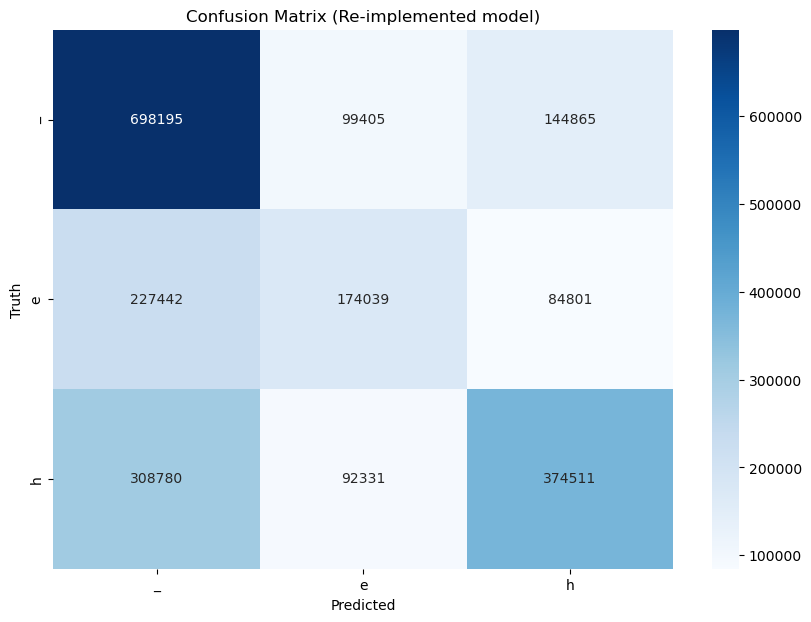

Accuracy (model 1): 0.5655790840825651
68887/68887 [==============================] - 66s 961us/step


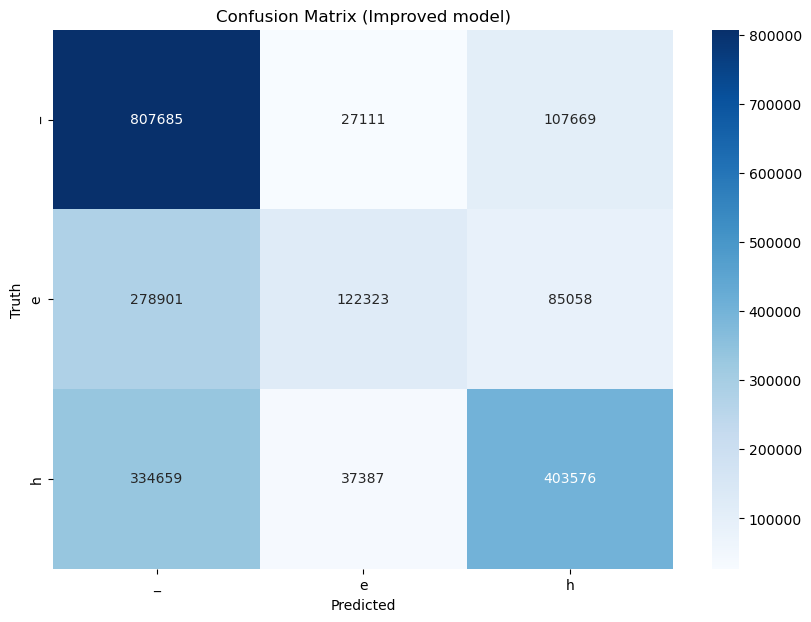

Accuracy (model 2): 0.6049731238281794


In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Predict classes
y_pred_prob = model1.predict(X)
y_pred = y_pred_prob.argmax(axis=-1)

# Compute confusion matrix
cm = confusion_matrix(Y, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['_','e','h'], yticklabels=['_','e','h'],)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix (Re-implemented model)')
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(Y, y_pred)

# Print the accuracy
print(f'Accuracy (model 1): {accuracy}')

## Predict classes
y_pred_prob = model2.predict(X)
y_pred = y_pred_prob.argmax(axis=-1)

# Compute confusion matrix
cm = confusion_matrix(Y, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['_','e','h'], yticklabels=['_','e','h'],)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix (Improved model)')
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(Y, y_pred)

# Print the accuracy
print(f'Accuracy (model 2): {accuracy}')


In [48]:
# Calculate the accuracy
accuracy = accuracy_score(Y, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy}')

Accuracy: 0.6049731238281794


In [49]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV
# Convert data and labels to numpy arrays
X = np.array(data_windows)
Y = np.array(labels_windows)

#subset_size = int(0.01 * len(X))  # Use 50% of the data
#X_train, X_test, Y_train, Y_test = train_test_split(X[:subset_size], Y[:subset_size], test_size=0.2, random_state=42)

# Create an SVM with specific hyperparameters
clf = svm.SVC(C=1.0, gamma='scale', kernel='rbf', class_weight='balanced')

# Fit the model to the data
clf.fit(X_train, y_train)

# Get the SVM's predictions on the test data
Y_pred = clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, Y_pred))



              precision    recall  f1-score   support

           0       0.59      0.31      0.41      1926
           1       0.29      0.44      0.35       748
           2       0.30      0.47      0.36       849

    accuracy                           0.38      3523
   macro avg       0.39      0.41      0.37      3523
weighted avg       0.46      0.38      0.39      3523

